#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 8: Training a Linear Classifier With Numerical and Categorical Features
**Learning Objectives:**
  * Introduce logistic regression to train a binary classifier.
  * Understand metrics such as ROC curves, AUC, log loss, classification errors.
  * Train a `LinearClassifier` using the raw numerical and categorical features.


### Standard Set-up

We begin with the standard set-up as seen in the last lab, however, we use a different data set based on 1990 census data from California. Since this data set has a header row, we don't need to provide the column names.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


In this lab, you will solve a binary classification problem: Given census data about a person such as age, gender, education and occupation, we will predict whether or not the person earns more than 50,000 dollars a year (the target label). We will train a linear classifier that given the feature values for an individual outputs a number between 0 and 1, which can be interpreted as the probability that the individual has an annual income of over 50K.

The dataset we'll be using is the [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income). We load the [training data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) durectly from here. Most of the column names should be self explanatory if not you can read more about it at the website linked above. The number of people the census takers believe that each observation represents (sample weight) could be used to weight the examples during training but for the purpose of this lab you can ignore it.  You don't want to use it as a feature.

In [0]:
import tempfile
import urllib
train_file = tempfile.NamedTemporaryFile()
urllib.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data", train_file.name)

COLUMNS = ["age", "workclass", "sample_weight", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
census_df = pd.read_csv(train_file, names=COLUMNS, skipinitialspace=True)
# Show the first 5 rows of the table.
census_df.head(5)

,age,workclass,sample_weight,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Setting Up the Feature Columns and Input Function for TensorFlow
As in the past labs, we define `input_fn` to define a `FeatureColumn` for each categorical and numerical feature, and then define `train_input_fn` to use the training data, `eval_input_fn` to use the validation data, and `test_input_fn` to use the test data.

In [0]:
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
LABEL = "income_over_50k"

def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping each numerical feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values) 
                    for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(training_examples)

def eval_input_fn():
  return input_fn(validation_examples)

def test_input_fn():
  return input_fn(test_examples)

##Prepare Features

Here is a basic implementation of `PrepareFeatures` for you to use.  Feel free to modify this to use feature normalization other than just linear scaling.  

Note that for linear classification with just two labels, the labels must be 0 (think of this as false) and 1 (think of this as true).  Since `income_brackets` is a string, we must convert it to an integer. This can be done using a lambda function that outputs a Boolean  value, and then casts it to an integer. We have provided this for you.

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain the data.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in NUMERICAL_COLUMNS:
    processed_features[feature] = linear_scale(dataframe[feature])
    
  # Convert the output target to 0 (for <=50k) and 1 (> 50k)
  processed_features[LABEL] = dataframe["income_bracket"].apply(
      lambda x: ">50K" in x).astype(int)
  
  return processed_features

###Divide the provided data for training our model into training and validation sets

As we've done in the past, let's divide the data into a ***training set*** and ***validation set***.  There are 16281 examples so let's set aside 4000 for our validation data.  Let's not forget to randomize the order before splitting the data so that our validation set is a representative sample.

In [0]:
census_df = census_df.reindex(np.random.permutation(census_df.index))
training_examples = prepare_features(census_df.head(12281))
validation_examples = prepare_features(census_df.tail(4000))

### Load the Test Data

Like with the housing data, this data set has a specified [test data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test) that we can use at the end to look at the performance for our final classifier.  We will load it and do the pre-processing here but this should not be used in training or selecting any of the hyperparameters.

In [0]:
test_file = tempfile.NamedTemporaryFile()
urllib.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test", test_file.name)

census_df_test = pd.read_csv(test_file, names=COLUMNS, skipinitialspace=True, skiprows=1)
test_examples = prepare_features(census_df_test)

### Functions to help visualize our results

Since this is a classification problem, the calibration plot is not a good visualization tool. Instead we use an **ROC curve** in which the x-axis is the false positive rate and the y-axis is the true positive rate.  An ROC curve is a very good way to visualize the quality of a binary classifier and also to pick a threshold when making a binary prediction.  Recall that the line `x=y` corresponds to a random classifier.  **AUC** (the area under the ROC curve) has the nice *probabilistic interpretation that a random positive example is predicted to be more likely to be positive than a random negative example*.

Our implementation of `make_roc_curve` uses the [sklearn metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) class. There are a lot of tools already available within Python libraries so be sure and look for those. 

In [0]:
def make_roc_curve(predictions, targets):
  """ Plots an ROC curve for the provided predictions and targets.

  Args:
    predictions: the probability that the example has label 1.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      targets, predictions)
  
  plt.ylabel("true positive rate")
  plt.xlabel("false positive rate")
  plt.plot(false_positive_rate, true_positive_rate)
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of training losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

### Compute Loss

For classification problems, we generally would like our output to be a probability distribution over the possible classes.  When we have two classes the **log loss** is a measure of how close the predicted distribution is to the target distribution, and that is the metric that we will optimize. Again, we use the [sklearn metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) class. 

In [0]:
def compute_loss(model, input_fn, targets):
  """ Computes the log loss for training a linear classifier.
  
  Args:
    model: the trained model to use for making the predictions.
    input_fn: the input_fn to use to make the predicitons.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The log loss for the provided predictions and targets.
  """      
  
  predictions = np.array(list(model.predict_proba(input_fn=input_fn)))
  return metrics.log_loss(targets, predictions[:, 1])

##Setting up the Features

We will set things up showing you an example of how to set up each of the kind of features you will be using.  Then you can add in additional features.

####Categorical Feauture Columns with known values.

When the values are known you can simply use a line like below.  If you would view the weights, index 0 will be the first key provided, index 1, the next key,.....

```
      gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender", keys=["Female", "Male"])
  
  ```
####Categorical Feature Columns without known values

Since you don't always know the possible values you can instead assign an index to each possible value via hashing where `hash_bucket_size` is the number of hash buckets used.

```
      education = tf.contrib.layers.sparse_column_with_hash_bucket("education", hash_bucket_size=100)
```

####Numerical Feature Columns
As we have seen in past labs, we can directly use numerical features as long as appropriate scaling has been applied. The provided implementation of `prepare_features` linearly scales all numerical featuers to fall in [0,1]
```
   age = tf.contrib.layers.real_valued_column("age") 
```

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample of creating a real-valued column that can be used for numeric data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age]
 
  return feature_columns

### Train Model

For the most part `define_linear_classifier` is like `define_linear_regressor` with the changes of using the log loss to optimize and the ROC curve to visualize the model quality.  As before we plot a learning curve to see if the model is converging, to help tune the learning rate, and to check if we are overfitting by looking at the loss on the validation data.

In [0]:
def define_linear_classifier(learning_rate):
  """ Defines a linear classifer to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear classifier created with the given parameters.
  """
  linear_classifier = tf.contrib.learn.LinearClassifier(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_classifier

def train_model(model, steps):
  """Trains a linear classifier.
  
  Args:
    model: The model to train.
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained model.
  """
  # In order to see how the model evolves as we train it, we divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training and validation losses so we can
  # generate a learning curve.
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the model for steps_per_period steps.
    model.fit(input_fn=train_input_fn, steps=steps_per_period)
    
    # Compute the loss between the predictions and the correct labels, append
    # the training and validation loss to the list of losses used to generate
    # the learning curve after training is complete and print the current
    # training loss.
    training_loss = compute_loss(model, train_input_fn,
                                 training_examples[LABEL])
    validation_loss = compute_loss(model, eval_input_fn,
                                   validation_examples[LABEL])
    training_losses.append(training_loss) 
    validation_losses.append(validation_loss) 
    print "  Training loss after period %02d : %0.3f" % (period, training_loss)
      
  # Now that training is done print the final training and validation losses.  
  print "Final Training Loss: %0.3f" % training_loss
  print "Final Validation Loss: %0.3f" % validation_loss 
  
  # Generate a figure with the learning curve on the left and an ROC curve on
  # the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (Loss vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("ROC Curve on Validation Data")
  validation_probabilities = np.array(list(model.predict_proba(
    input_fn=eval_input_fn)))
  # ROC curve uses the probability that the label is 1.
  make_roc_curve(validation_probabilities[:, 1], validation_examples[LABEL])
   
  return model

## Task 1 - Train a Linear Classifier (1/2 point)

Let's start by just training the model with the three features already set-up in `construct_feature_columns`. Without changing anything but the learning_rate and number of steps to train, train the best model you can.

Training model...
  Training loss after period 00 : 0.538
  Training loss after period 01 : 0.519
  Training loss after period 02 : 0.509
  Training loss after period 03 : 0.502
  Training loss after period 04 : 0.497
  Training loss after period 05 : 0.493
  Training loss after period 06 : 0.489
  Training loss after period 07 : 0.486
  Training loss after period 08 : 0.484
  Training loss after period 09 : 0.482
Final Training Loss: 0.482
Final Validation Loss: 0.473


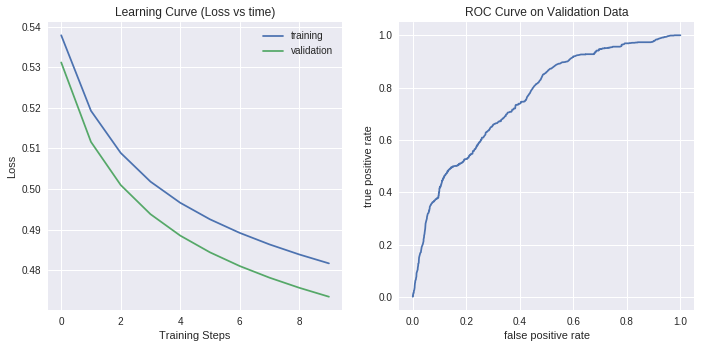

In [0]:
LEARNING_RATE = 0.1
STEPS = 500

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(linear_classifier, steps=STEPS)

You can get a variety of evaluation metrics on the validation data to help you understand the quality of the models you have trained.  As we mentioned above,  **AUC** (the area under the ROC curve) has the nice *probabilistic interpretation that a random positive example is predicted to be more likely to be positive than a random negative example*.  The accuracy is the fraction of examples (in the provided data set) for which the predicted value is the same as the target label when a threshold of 0.5 on the output (the probability that the example is positive) is used as a threshold for classifying an example as positive or negative.  Finally the loss is the log loss (which is the metric being optimized).

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=eval_input_fn, steps=1)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']
print "Loss on the validation set: %0.2f" % evaluation_metrics['loss']

AUC on the validation set: 0.76
Accuracy on the validation set: 0.77
Loss on the validation set: 0.47


## Task 2 - Train a Better Linear Classifier (4 points)

Using your choice of categorical and numerical features and hyperparameters, train the best linear classifier you can.

For your convenience we have duplicated the definition of `construct_feature_columns` and included it below with the code to train the model. **So far no changes have been made -- that's what you need to do here.**

Feel free to duplicate the code box below if you want to see the results of several different options at once.

**WARNING: As discussed in the slides, because the log loss has a gradient that goes to infinity as your prediction approaches the target value, when training a logistic regression model with a lot of features and thus the possibility to overfit the training data, you can get a gradient that is so large that your model overflows.  If you see an error indicating that you divided by zero or a loss of NaN, then most likely this situation has occured. The way to address this problem is to introduce regularization (which you will learn how to do in TensorFlow soon). For now, the solution is to reduce the learning rate and/or the number of training steps even if that means that your model is undertrained.**

Training model...
  Training loss after period 00 : 0.610
  Training loss after period 01 : 0.574
  Training loss after period 02 : 0.555
  Training loss after period 03 : 0.545
  Training loss after period 04 : 0.538
  Training loss after period 05 : 0.533
  Training loss after period 06 : 0.529
  Training loss after period 07 : 0.525
  Training loss after period 08 : 0.522
  Training loss after period 09 : 0.519
Final Training Loss: 0.519
Final Validation Loss: 0.512


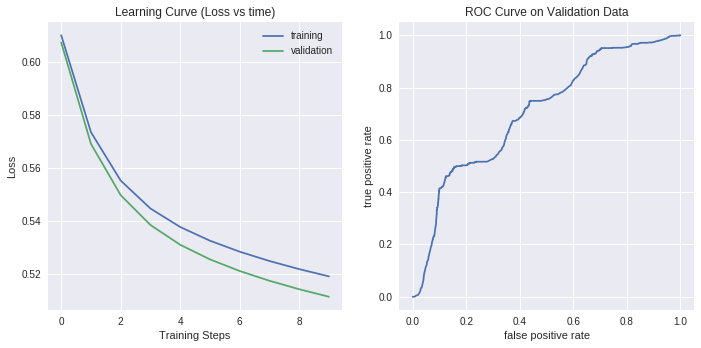

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample of creating a real-valued column that can be used for numerical data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age]
 
  return feature_columns

LEARNING_RATE = 0.1
STEPS = 100

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(linear_classifier, steps=STEPS)

Let's look at the evaluation metrics for your trained model.

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=eval_input_fn, steps=1)

print "AUC on the validation set: %0.2f" % evaluation_metrics['auc']
print "Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy']
print "Loss on the validation set: %0.2f" % evaluation_metrics['loss']

Once you've picked the hyperparameters (using the validation data), you can compute these metrics on the test data.

## Task 3 - Look at Evaluation Metrics on the Test Data (1/2 point)

In the first code box below put and execute code to compute the accuracy and AUC of your model on the test data.  Then in your own words interpret what these numbers are telling you about how your model will perform.


In [0]:
# Put code here to compute accuracy and AUC on the test input. Use what is done for the validation data to guide you.

In [0]:
"""
Explain in your own words what the accuracy and AUC values are saying about how your model will perform.


"""